In [43]:
import torch
import numpy as np
import pandas as pd
from matplotlib.pyplot import savefig

In [44]:
### Class that simulates evolution of bee hive
cos = torch.cos
sin = torch.sin
e = torch.exp
class Hive:
    def __init__(self,**args):
        for k,v in args.items():
            setattr(self,k,v)
    ## dynamics
    def dB_o(self,args):
        return self.L * self.S(args) - self.phi_o*args['B_o']
    def dB_c(self,args):
        return self.phi_o*args['B_o'] - self.phi_c*args['B_c'] - self.m_c*args['B_c']
    def dH(self,args):
        return self.phi_c*args['B_c'] - self.Rp(args)*args['H'] - self.Rn(args)*args['H']
    def dF_p(self,args):
        return self.Rp(args)*args['H'] - self.m_p*args['F_p']
    def dF_n(self,args):
        return self.Rn(args)*args['H'] - self.m_n*args['F_n']
    def df_p(self,args):
        return self.mu_p(args)*self.c*args['F_p'] - \
            self.gamma_bo*args['B_o'] - self.gamma_h*args['H'] 
    def df_n(self,args):
        return self.mu_n(args)*self.c*args['F_n'] - \
            self.delta_bo*args['B_o'] - self.delta_A*(args['H']+args['F_p']+args['F_n'])
    def update_bees(self,args):
        bees = {'B_o':args['B_o']+self.dB_o(args),
                'B_c':args['B_c']+self.dB_c(args),
                'H':args['H']+self.dH(args),
                'F_p':args['F_p']+self.dF_p(args),
                'F_n':args['F_n']+self.dF_n(args),
                'f_p':args['f_p']+self.df_p(args),
                'f_n':args['f_n']+self.df_n(args),
                't':args['t']+1}
        return bees
    ## survival and transition functions
    def S(self,args):
        H,f_n,f_p = args['H'],args['f_n'],args['f_p']
        v,b,K = self.v,self.b,self.K
        return H/(H+v)*f_n/(f_n+b)*f_p**2/(f_p**2+K*H)
    def Rp(self,args):
        f_p,F_p,F_n,H = args['f_p'],args['F_p'],args['F_n'],args['H']
        a_min,a_max,K,delta = self.amin_p,self.amax_p,self.K,self.delta
        return a_min + a_max*(1-f_p**2/(f_p**2+K*H)) - delta*F_p/(F_p+F_n+H)
    def Rn(self,args):
        f_n,F_p,F_n,H = args['f_n'],args['F_p'],args['F_n'],args['H']
        a_min,a_max,b,delta = self.amin_n,self.amax_n,self.b,self.delta
        return a_min + a_max*(1-f_n/(f_n+b)) - delta*F_n/(F_p+F_n+H)
    def mu_p(self,args):
        return 0.5*(cos(args['t']*np.pi/180)+2.5)
    def mu_n(self,args):
        return 0.5*(sin(args['t']*np.pi/180)+2.5)

In [ ]:
class Hive2(Hive):
    def __init__(self, **args):
        super().__init__(**args)
        
    def S(self,args):
        H,f_n,f_p = args['H'],args['f_n'],args['f_p']
        s_H,s_p,s_n = self.s_H,self.s_p,self.s_n
        return 0.8*(1-e(-s_H*H))*(1-e(-s_p*f_p))*(1-e(-s_n*f_n))
    def Rp(self,args):
        f_p,f_n,F_p,F_n,H = args['f_p'],args['f_n'],args['F_p'],args['F_n'],args['H']
        r_p,r_I,b = self.r_p,self.r_I,self.b
        return b*(1-0.5*e(-r_p*(f_p/(f_p+f_n+0.01))))*(1-e(-r_I*(H/(H+F_p+F_n))))
    def Rn(self,args):
        f_p,f_n,F_p,F_n,H = args['f_p'],args['f_n'],args['F_p'],args['F_n'],args['H']
        r_n,r_I,b = self.r_n,self.r_I,self.b
        return b*(1-0.5*e(-r_n*(f_p/(f_p+f_n+0.01))))*(1-e(-r_I*(H/(H+F_p+F_n))))

In [45]:
### function that runs hive simulation over multiple time steps, typically one year
def simulate_hive(hive_args,bees,time_steps,hive_class=Hive):
    '''
    run hive through consecutive days
    hive_args: dict containing hive parameters that determine how hive evolves from one day to the next
    bees: dict containing initial counts of brood, capped brood, hive bees, pollen foragers, nectar foragers, and store of nectar and pollen
    time_steps: number of days to run simulation over
    hive_class: Hive or a subclass of Hive that implements the hive
    '''
    hive = hive_class(**hive_args)
    all_bees = [bees]
    hive_out = [[v.item() for v in all_bees[-1].values()]]
    for step in range(time_steps):
        all_bees.append(hive.update_bees(all_bees[-1]))
        hive_out.append([v.item() for v in all_bees[-1].values()])
    hive_out = pd.DataFrame(hive_out,columns = list(bees.keys())).set_index('t')
    return hive_out,all_bees

In [46]:
### extract derivatives with respect to different input parameters
def get_derivs(hives,hive_args_torch,normalize = True):
    '''
    function to extract derivatives from simulation output
    hives: list of dicts, for each day of simulation, containing counts of bees and store of pollen/nectar
    hive_args: dict with simulation parameters, we will take derivative of each output count with respect to each parameter
    normalize: whether or not to adjust derivatives to represent change of 1% of magnitude of simulation parameter
    '''
    derivs = {}
    for k,v in hives[-1].items():
        if k != 't':
            v.backward(retain_graph=True)
            derivs[k] = pd.Series({k2:v2.grad.item() for k2,v2 in hive_args_torch.items()})
            for v2 in hive_args_torch.values():
                v2.grad = None
    derivs = pd.concat(derivs,axis=1)
    if normalize:
        val = pd.Series({k:v.item() for k,v in hive_args_torch.items()})
        val1pct = val*0.01
        derivs = derivs.mul(val1pct,0)
    return derivs

In [67]:
### present results
def present_results(all_bees, derivs, scenario, save_dir = '/home/max/work/challenge/graphs/'):
    all_bees.columns = ['Young Brood','Capped Brood','Hive Bees','Pollen Foragers','Nectar Foragers','Pollen Stored','Nectar Stored']
    derivs.columns = all_bees.columns
    all_bees.iloc[:,:5].plot(grid=True,title=f'Bee counts in {scenario} scenario')
    if save_dir is not None:
        savefig(f'{save_dir}{scenario}_bee_counts.png')
    all_bees.iloc[:,5:].plot(grid=True,title=f'Food stored in {scenario} scenario')
    if save_dir is not None:
        savefig(f'{save_dir}{scenario}_food_store.png')
    derivs.index = ['eggs','hive_bees_for_brood_surv','nectar_for_brood_surv','pollen_recruit_rate_1','pollen_recruit_rate_2','nectar_rectuit_rate_1',
                    'nectar_recruit_rate_2','excess_foragers','1/larva_duration','1/capped_duration','pollen_eaten_per_brood','nectar_eaten_per_brood',
                    'pollen_eaten_per_hiveb','nectar_eaten_per_worker','food_gathered_per_worker','mortality_capped','mortatiliy_pollen',
                    'mortality_nectar','nurse_bee_protein_sat']
    derivs.drop('mortality_capped')
    if save_dir is not None:
        derivs.style.to_latex(f'{save_dir}{scenario}_derivs.tex',hrules=True)
    return derivs

In [32]:
### typical parameters representing hive
hive_args = \
    {'L': 2000,        # number of eggs per day
     'v': 5000,        # number of hive bees corresponding to survival of eggs of 50%
     'b': 500,         # how much nectar needs to be stored corresponding to survival of eggs of 50%
     'amin_p': 0.25,   # recruitment rate 1 for hive bees to become pollen foragers
     'amax_p': 0.25,   # recruitment rate 2 for hive bees to become pollen foragers
     'amin_n': 0.25,   # recruitment rate 1 for hive bees to become nectar foragers
     'amax_n': 0.25,   # recruitment rate 2 for hive bees to become nectar foragers
     'delta': 0.75,    # effect of excess foragers on recruitment
     'phi_o': 1/9,     # 1/(duration of egg + larva state)
     'phi_c': 1/12,    # 1/(duration of capped brood state)
     'delta_bo': 0.018,# daily nectar consumption of uncapped brood member
     'gamma_bo': 0.018,# daily pollen consumption of uncapped brood member
     'gamma_h': 0.007, # daily pollen consumption of hive bee
     'delta_A': 0.007, # daily nector consumption of adult forager bee
     'c': 0.1,         # food gathered per day by forager
     'm_c':0,          # daily mortality rate of capped brood
     'm_p':0.1,        # daily mortality rate of pollen forager
     'm_n':0.1,        # daily mortality rate of nectar forager
     'K':8.0}          # maximum amount of protein that saturates nurse bee
hive_args_torch = {k:torch.tensor([float(v)],requires_grad=True) for k,v in hive_args.items()}

In [55]:
### base case bee counts
bees = dict(zip(['B_o','B_c','H','F_p','F_n','f_p','f_n','t'],[0.0,0.0,16000.0,2000.0,6000.0,0.0,0.0,0.0]))
print(bees)
bees = {k:torch.Tensor([v]) for k,v in bees.items()}

{'B_o': 0.0, 'B_c': 0.0, 'H': 16000.0, 'F_p': 2000.0, 'F_n': 6000.0, 'f_p': 0.0, 'f_n': 0.0, 't': 0.0}


,Young Brood,Capped Brood,Hive Bees,Pollen Foragers,Nectar Foragers,Pollen Stored,Nectar Stored
eggs,180.453491,240.628033,184.034443,100.264750,100.299864,2103.730469,1715.780029
hive_bees_for_brood_surv,-49.685535,-66.295063,-50.808060,-27.677232,-27.654505,-700.844097,-637.898254
nectar_for_brood_surv,-0.899687,-1.240216,-1.415299,-0.683860,-0.412334,-61.146564,-41.633148
pollen_recruit_rate_1,-42.515718,-56.737144,-155.237402,12.343350,-59.661211,1052.256172,-1558.889844
pollen_recruit_rate_2,-0.033559,-0.048351,-0.056208,-0.027760,-0.018960,-16.786675,-46.510938
nectar_rectuit_rate_1,-40.819341,-54.417476,-152.601572,-58.481987,13.172411,-1582.120469,1124.389219
nectar_recruit_rate_2,-0.179129,-0.247470,-0.623862,-0.250027,0.018944,-60.716265,-15.519277
excess_foragers,65.285896,87.083855,241.143604,36.258801,36.321134,457.268203,350.414180
1/larva_duration,-129.471537,0.860595,0.966566,0.470401,0.294568,886.732645,905.522923
1/capped_duration,0.170861,-173.126685,0.320893,0.165913,0.126038,170.137857,205.251451


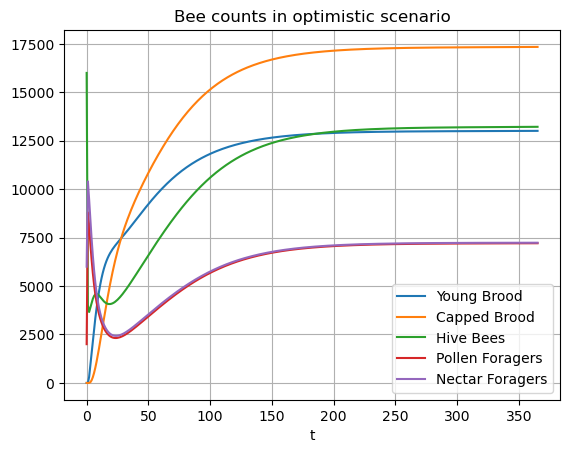

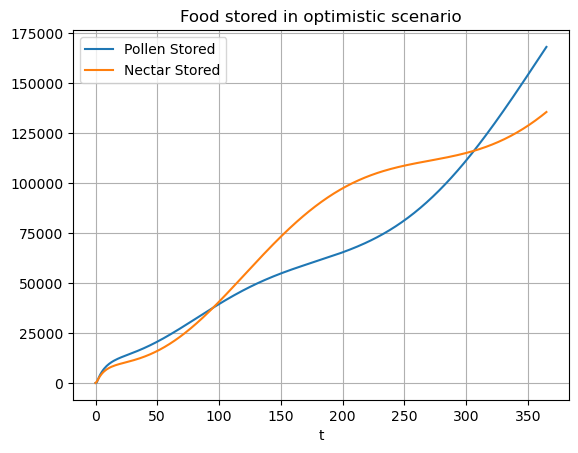

In [69]:
### Base case scenario
all_bees,hive_out = simulate_hive(hive_args_torch,bees,365)
derivs = get_derivs(hive_out,hive_args_torch,True)
present_results(all_bees,derivs,'optimistic')

,Young Brood,Capped Brood,Hive Bees,Pollen Foragers,Nectar Foragers,Pollen Stored,Nectar Stored
eggs,139.382877,179.789753,120.924740,69.381247,79.916983,244.485397,-16.211938
hive_bees_for_brood_surv,-57.478493,-75.619233,-54.158199,-30.157936,-32.246423,-103.471053,-9.765597
nectar_for_brood_surv,-9.833577,-13.018100,-12.940143,-6.509632,-4.749373,-40.553117,21.694922
pollen_recruit_rate_1,-161.514199,-223.403984,-272.502734,-69.990000,-113.726387,620.559609,-183.078711
pollen_recruit_rate_2,-4.761295,-7.019079,-6.434433,-3.341121,-2.789660,-1.795991,-6.441996
nectar_rectuit_rate_1,196.863574,285.234160,190.684336,109.044453,125.494600,-183.890059,358.678398
nectar_recruit_rate_2,10.917532,15.274290,5.897433,4.050155,7.103242,-27.888577,26.282690
excess_foragers,-34.320179,-57.498336,61.006578,-32.277151,-13.795260,-315.550225,-154.492075
1/larva_duration,117.130105,314.877676,286.411894,145.304194,113.899141,899.106743,331.911947
1/capped_duration,17.615774,-114.597595,22.789508,11.722772,9.487765,66.894904,24.421236


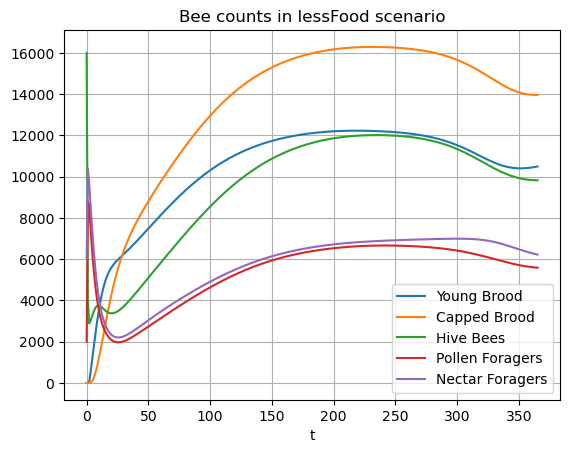

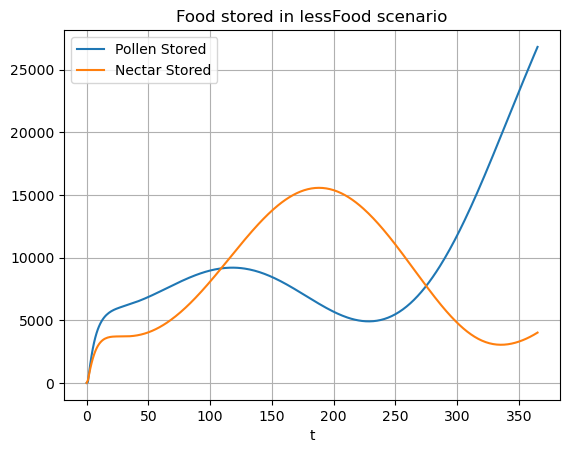

In [70]:
### Less food brought in by foragers
less_food = hive_args.copy()
less_food['c'] = 0.05
less_food_torch = {k:torch.tensor([float(v)],requires_grad=True) for k,v in less_food.items()}
all_bees,hive_out = simulate_hive(less_food_torch,bees,365)
derivs = get_derivs(hive_out,less_food_torch,True)
present_results(all_bees,derivs,'lessFood')

,Young Brood,Capped Brood,Hive Bees,Pollen Foragers,Nectar Foragers,Pollen Stored,Nectar Stored
eggs,0.653895,0.963549,0.451229,0.340802,0.540340,-1.854909,2.377025
hive_bees_for_brood_surv,-0.492755,-0.728676,-0.337248,-0.257026,-0.412629,1.406111,-1.258481
nectar_for_brood_surv,0.107443,0.166970,0.084433,0.063739,0.103658,0.082296,2.193829
pollen_recruit_rate_1,-3.490945,-5.125751,-2.574713,-1.795053,-2.904726,9.313970,-21.832698
pollen_recruit_rate_2,-0.454226,-0.665483,-0.325135,-0.238601,-0.367074,1.310363,-3.064862
nectar_rectuit_rate_1,2.007665,3.003116,1.406287,1.073181,1.742264,-3.995923,13.543539
nectar_recruit_rate_2,1.073563,1.604584,0.735480,0.566145,0.932765,-2.215445,7.605909
excess_foragers,0.547539,0.741188,0.496386,0.243369,0.367625,-3.032431,2.135610
1/larva_duration,0.592866,1.213155,0.646214,0.509392,0.869690,2.725624,0.688229
1/capped_duration,-0.001934,-0.296841,-0.048230,-0.044351,-0.091789,-0.803825,1.237428


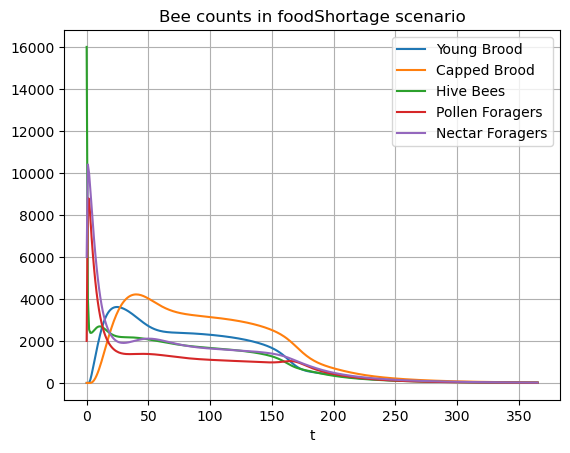

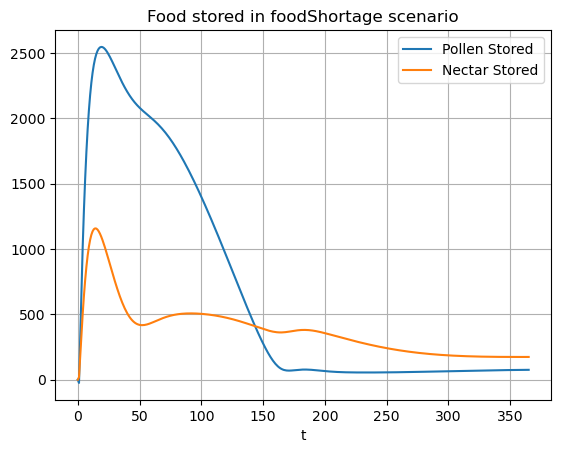

In [71]:
### Severe food shortage
less_food = hive_args.copy()
less_food['c'] = 0.025
less_food_torch = {k:torch.tensor([float(v)],requires_grad=True) for k,v in less_food.items()}
all_bees,hive_out = simulate_hive(less_food_torch,bees,365)
derivs = get_derivs(hive_out,less_food_torch,True)
present_results(all_bees,derivs,'foodShortage')

,Young Brood,Capped Brood,Hive Bees,Pollen Foragers,Nectar Foragers,Pollen Stored,Nectar Stored
eggs,182.304077,243.030338,123.501692,50.439820,50.809641,463.057022,279.049473
hive_bees_for_brood_surv,-78.740937,-105.063415,-53.666288,-21.892244,-21.915686,-227.474070,-173.595989
nectar_for_brood_surv,-5.454236,-7.370614,-4.821566,-1.844350,-1.261973,-38.200185,-12.476239
pollen_recruit_rate_1,-64.419028,-85.783477,-93.680645,-4.255661,-31.394905,447.088281,-521.036680
pollen_recruit_rate_2,-0.553863,-0.760121,-0.496307,-0.189758,-0.135280,-2.009998,-22.903667
nectar_rectuit_rate_1,-43.223994,-57.905698,-75.408511,-25.150022,0.881106,-523.898086,472.467344
nectar_recruit_rate_2,-1.087579,-1.476073,-1.782039,-0.605879,-0.033061,-35.123689,6.477166
excess_foragers,73.208774,97.740872,114.968379,20.213895,20.559523,77.071099,33.410845
1/larva_duration,-88.141450,17.347372,11.342085,4.286236,2.807452,635.002227,605.697782
1/capped_duration,1.935205,-132.282009,1.749726,0.675054,0.484895,63.225529,78.489540


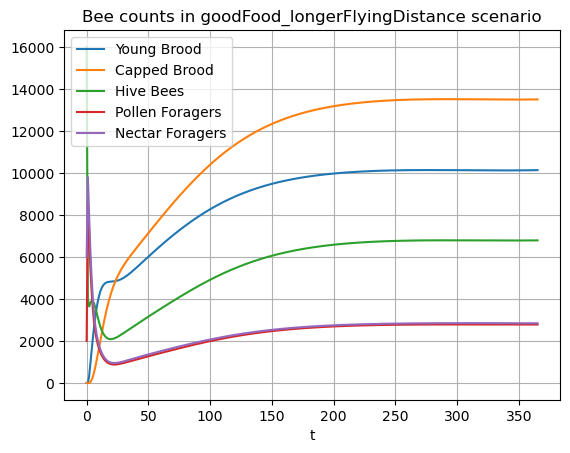

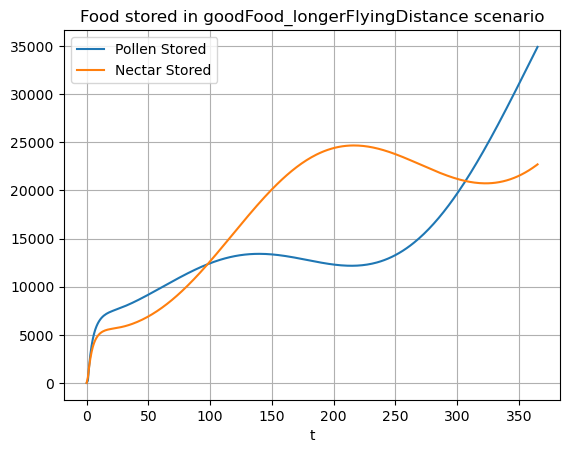

In [72]:
### Longer fly distance
fly_longer = hive_args.copy()
fly_longer['c'] = 0.025*4
fly_longer['m_p'] = 0.2
fly_longer['m_n'] = 0.2
fly_longer_torch = {k:torch.tensor([float(v)],requires_grad=True) for k,v in fly_longer.items()}
all_bees,hive_out = simulate_hive(fly_longer_torch,bees,365)
derivs = get_derivs(hive_out,fly_longer_torch,True)
present_results(all_bees,derivs,'goodFood_longerFlyingDistance')

,Young Brood,Capped Brood,Hive Bees,Pollen Foragers,Nectar Foragers,Pollen Stored,Nectar Stored
eggs,117.005882,147.122698,52.997708,18.045305,21.018338,-18.642205,10.646908
hive_bees_for_brood_surv,-83.690125,-105.141413,-37.996179,-12.924697,-14.986826,11.280426,-8.703518
nectar_for_brood_surv,-10.531893,-14.318759,-5.857434,-1.975326,-2.058705,-5.730741,13.854557
pollen_recruit_rate_1,-223.991602,-264.025078,-119.001777,-30.575503,-35.749219,149.088916,-150.923828
pollen_recruit_rate_2,-14.351932,-17.099745,-7.060771,-2.278941,-2.048561,6.811467,-10.887126
nectar_rectuit_rate_1,135.895889,159.935117,56.363135,18.856105,21.168862,-61.218218,137.012139
nectar_recruit_rate_2,13.985000,15.714664,4.507519,1.553392,2.185602,-12.051565,18.773638
excess_foragers,48.264536,57.548621,36.488401,6.721859,7.955329,-47.234344,0.709260
1/larva_duration,98.235200,194.546390,79.536294,26.819238,28.791485,259.194828,60.593117
1/capped_duration,13.417617,-41.187547,6.898653,2.300230,2.281685,5.936523,7.677604


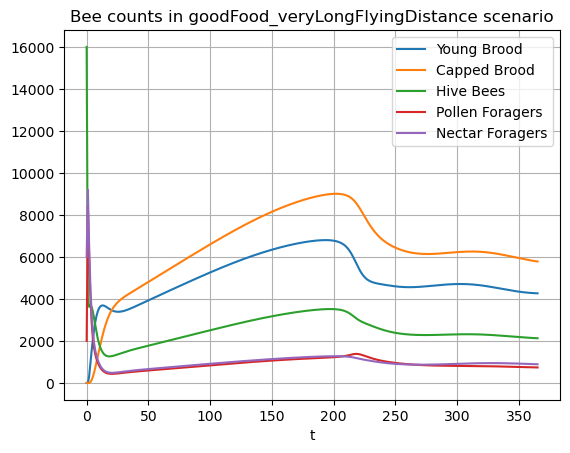

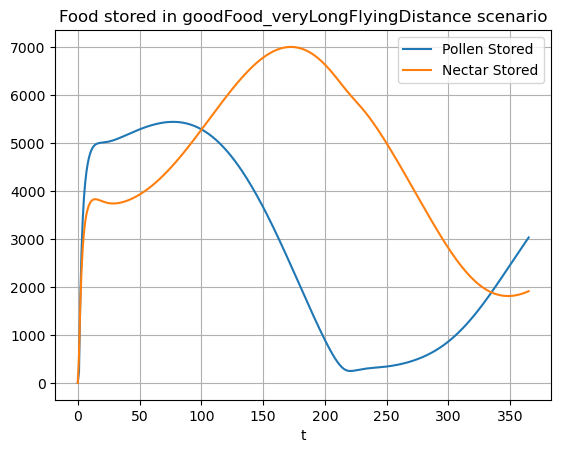

In [73]:
### very long fly distance
fly_longer = hive_args.copy()
fly_longer['c'] = 0.025*4
fly_longer['m_p'] = 0.3
fly_longer['m_n'] = 0.3
fly_longer_torch = {k:torch.tensor([float(v)],requires_grad=True) for k,v in fly_longer.items()}
all_bees,hive_out = simulate_hive(fly_longer_torch,bees,365)
derivs = get_derivs(hive_out,fly_longer_torch,True)
present_results(all_bees,derivs,'goodFood_veryLongFlyingDistance')